In [355]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from itertools import product
from typing import Dict, List, Any
from math import inf

In [356]:
climate_df: pd.DataFrame = pd.read_csv("../data/Cleaned_Data_Seasonal.csv")
climate_df = climate_df[climate_df["Region"].isin(["SPL", "NPL"])]
climate_df.head()

,Region,Year,Season,ACI_Combined_Seasonal_Smoothed,ACI_Combined_Seasonal_Unsmoothed,CDD_Seasonal_Smoothed,CDD_Seasonal_Unsmoothed,CDD_Seasonal_Unsmoothed_Unstandardized,Rx5Day_Seasonal_Smoothed,Rx5Day_Seasonal_Unsmoothed,...,Sea_Level_Seasonal_Unsmoothed_Unstandardized,T10_Seasonal_Smoothed,T10_Seasonal_Unsmoothed,T10_Seasonal_Unsmoothed_Unstandardized,T90_Seasonal_Smoothed,T90_Seasonal_Unsmoothed,T90_Seasonal_Unsmoothed_Unstandardized,WP90_Seasonal_Smoothed,WP90_Seasonal_Unsmoothed,WP90_Seasonal_Unsmoothed_Unstandardized
7,NPL,1961,1,0.18,0.84,-0.32,0.75,33.90,-0.39,0.45,...,7395.00,-0.02,-1.52,2.29,-0.27,0.53,13.22,0.78,0.57,11.68
10,SPL,1961,1,-0.12,-0.05,0.82,-0.54,38.19,-0.21,1.27,...,6854.45,-0.20,-1.09,5.26,-0.09,-0.23,9.37,0.05,-0.44,9.16
22,NPL,1961,2,0.21,0.21,-0.26,0.54,33.15,-0.39,-1.47,...,7316.67,-0.07,0.14,10.91,-0.23,-0.18,9.29,0.82,1.27,12.95
25,SPL,1961,2,-0.13,-0.38,0.65,-0.43,38.55,-0.13,-1.28,...,6938.56,-0.22,-0.05,9.86,-0.14,-0.35,8.78,0.10,1.12,12.51
37,NPL,1961,3,0.23,0.65,-0.19,0.33,32.39,-0.53,-2.39,...,7428.33,-0.14,-1.40,5.31,-0.08,2.96,22.06,0.75,0.19,10.41


In [357]:
print(f"Records before dropping empty rows: {len(climate_df)}")
climate_df = climate_df.dropna()
print(f"Records after dropping empty rows: {len(climate_df)}")

Records before dropping empty rows: 500
Records after dropping empty rows: 500


In [358]:
def build_linear_regression_model(feature_df: pd.DataFrame, target_df: pd.Series):
    x_train, x_test, y_train, y_test = train_test_split(feature_df, target_df, test_size=0.3, random_state=1)
    x_train_const: pd.DataFrame = sm.add_constant(x_train)
    return sm.OLS(y_train, x_train_const.astype(float)).fit(), x_test, y_test

In [359]:
season_dummies: pd.DataFrame = pd.get_dummies(climate_df["Season"], prefix="Season")
time_features: pd.DataFrame = pd.concat([climate_df[["Year"]], season_dummies], axis=1)
target: pd.Series = climate_df["CDD_Seasonal_Smoothed"]

model, x_test, y_test = build_linear_regression_model(time_features, target)
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     CDD_Seasonal_Smoothed   R-squared:                       0.064
Model:                               OLS   Adj. R-squared:                  0.053
Method:                    Least Squares   F-statistic:                     5.872
Date:                   Sat, 17 Feb 2024   Prob (F-statistic):           0.000140
Time:                           14:17:39   Log-Likelihood:                -259.24
No. Observations:                    350   AIC:                             528.5
Df Residuals:                        345   BIC:                             547.8
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.5483 

In [360]:
def run_prediction(predictive_model, x_test_df: pd.DataFrame, y_test_df: pd.DataFrame):
    x_test_const: pd.DataFrame = sm.add_constant(x_test_df)
    y_prediction = predictive_model.predict(x_test_const)
    mse = mean_squared_error(y_test_df, y_prediction)
    r_squared = r2_score(y_test_df, y_prediction)
    
    print(f"The test data MSE is {round(mse, 3)}.")
    print(f"The test data r-squared value is {round(r_squared, 3)}.")
    return y_prediction

In [361]:
y_predictions = run_prediction(model, x_test, y_test)

The test data MSE is 0.336.
The test data r-squared value is 0.025.


In [362]:
def plot_actual_vs_predicted(actuals, predictions):
    plt.scatter(actuals, predictions, alpha=0.5)
    plt.title('Actual vs. Predicted CDD Values')
    plt.xlabel('Actual CDD')
    plt.ylabel('Predicted CDD')
    plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'k--', lw=2) 
    plt.grid(True)
    plt.show()

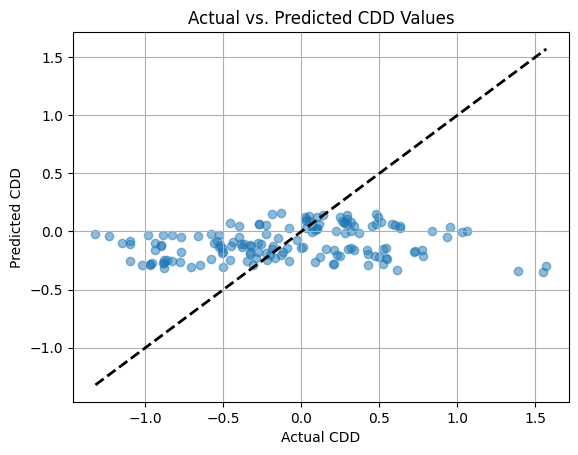

In [363]:
plot_actual_vs_predicted(y_test, y_predictions)

In [364]:
sea_level_time_features: pd.DataFrame = pd.concat([time_features, climate_df[["Sea_Level_Seasonal_Smoothed"]]], axis=1)

model, x_test, y_test = build_linear_regression_model(sea_level_time_features, target)
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     CDD_Seasonal_Smoothed   R-squared:                       0.089
Model:                               OLS   Adj. R-squared:                  0.075
Method:                    Least Squares   F-statistic:                     6.684
Date:                   Sat, 17 Feb 2024   Prob (F-statistic):           5.85e-06
Time:                           14:17:39   Log-Likelihood:                -254.54
No. Observations:                    350   AIC:                             521.1
Df Residuals:                        344   BIC:                             544.2
Df Model:                              5                                         
Covariance Type:               nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

In [365]:
y_predictions = run_prediction(model, x_test, y_test)

The test data MSE is 0.329.
The test data r-squared value is 0.047.


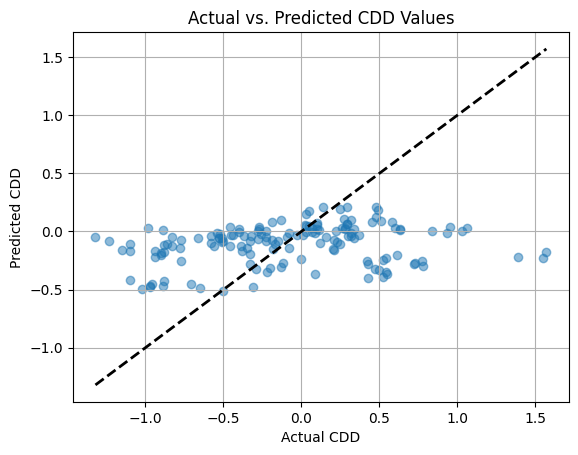

In [366]:
plot_actual_vs_predicted(y_test, y_predictions)

In [367]:
def generate_hyperparameters(params: Dict[str, List[Any]]) -> List[Dict[str, Any]]:
    keys = list(params.keys())
    values_product = product(*params.values())
    combinations = [{keys[i]: value for i, value in enumerate(values)} for values in values_product]
    return combinations

def find_optimal_hyperparameters(model_class, hyperparameters: List[Dict[str, Any]], features_df, target_series) -> Dict[str, Any]:
    x_train, x_test, y_train, y_test = train_test_split(features_df, target_series, test_size=0.3, random_state=1)
    
    min_mse = inf
    best_hyperparameters = None
    for hyperparameterSet in hyperparameters:
        model_instance = model_class(**hyperparameterSet, random_state=1)
        model_instance.fit(x_train, y_train)
        model_y_prediction = model_instance.predict(x_test)
        model_mse = mean_squared_error(y_test, model_y_prediction)
        
        if model_mse < min_mse:
            min_mse = model_mse
            best_hyperparameters = hyperparameterSet
            
    return best_hyperparameters

In [368]:
optimized_hyperparameters = find_optimal_hyperparameters(DecisionTreeRegressor, generate_hyperparameters({"max_depth": list(range(2, 21))}), sea_level_time_features, target)
print(f"The optimized hyperparameters are: {optimized_hyperparameters}")

The optimized hyperparameters are: {'max_depth': 13}


In [369]:
x_train, x_test, y_train, y_test = train_test_split(sea_level_time_features, target, test_size=0.3, random_state=1)
dt_regressor = DecisionTreeRegressor(**optimized_hyperparameters, random_state=1)
dt_regressor.fit(x_train, y_train)

y_predictions = dt_regressor.predict(x_test)
mse = mean_squared_error(y_test, y_predictions)
r_squared = r2_score(y_test, y_predictions)

print(f"The test data MSE is {round(mse, 3)}.")
print(f"The test data r-squared value is {round(r_squared, 3)}.\n")

The test data MSE is 0.028.
The test data r-squared value is 0.92.


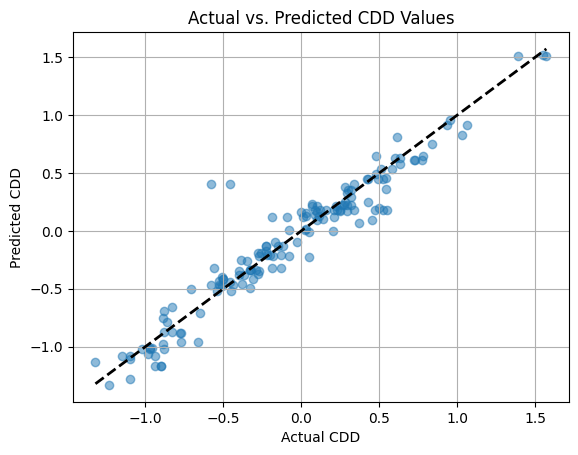

In [370]:
plot_actual_vs_predicted(y_test, y_predictions)

In [371]:
optimized_hyperparameters = find_optimal_hyperparameters(RandomForestRegressor, generate_hyperparameters({"max_depth": list(range(1, 21)), "n_estimators": range(10, 151, 10)}), sea_level_time_features, target)
print(f"The optimized hyperparameters are: {optimized_hyperparameters}")

The optimized hyperparameters are: {'max_depth': 14, 'n_estimators': 10}


In [372]:
x_train, x_test, y_train, y_test = train_test_split(sea_level_time_features, target, test_size=0.3, random_state=1)
rf_regressor = RandomForestRegressor(**optimized_hyperparameters, random_state=1)
rf_regressor.fit(x_train, y_train)

y_predictions = rf_regressor.predict(x_test)
mse = mean_squared_error(y_test, y_predictions)
r_squared = r2_score(y_test, y_predictions)

print(f"The test data MSE is {round(mse, 3)}.")
print(f"The test data r-squared value is {round(r_squared, 3)}.\n")

The test data MSE is 0.024.
The test data r-squared value is 0.93.


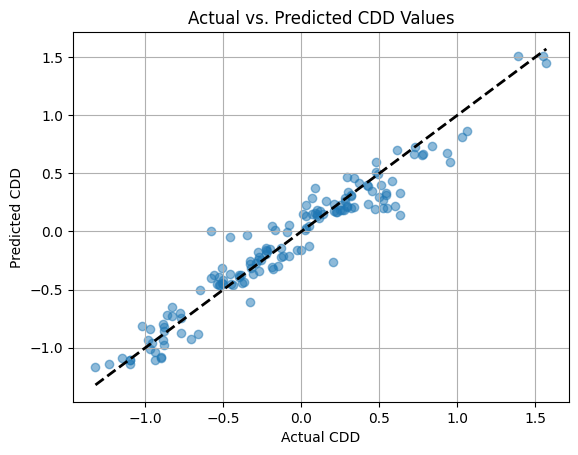

In [373]:
plot_actual_vs_predicted(y_test, y_predictions)